In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

IMG_WIDTH = 224
IMG_HEIGHT = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [3]:
from models import ResNet18, ResNet34, EnsembleModel, SiameseNet

In [5]:
import os
import random
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from IPython.display import clear_output

class SiameseAnimalDataset(Dataset):
    def __init__(self, root_dir, transform,
                 cat_vs_dog_model_path18, cat_vs_dog_model_path34,
                 cat_breed_model_path18, cat_breed_model_path34,
                 dog_breed_model_path18, dog_breed_model_path34):
        self.root_dir = root_dir
        self.transform = transform
        self.catdog_classifier = CatDogIdentifier(cat_vs_dog_model_path18, cat_vs_dog_model_path34)
        self.cat_breed_classifier = CatBreedClassifier(cat_breed_model_path18, cat_breed_model_path34)
        self.dog_breed_classifier = DogBreedClassifier(dog_breed_model_path18, dog_breed_model_path34)

        self.animal_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                            if os.path.isdir(os.path.join(root_dir, d))]
        
        self.data = []
        for (num_folder, folder) in enumerate(self.animal_dirs):
            print(f"Processing {folder} ({num_folder+1}/{len(self.animal_dirs)})...")
            images = [os.path.join(folder, f) for f in os.listdir(folder)
                      if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            for (num, img_path) in enumerate(images):
                try:
                    img = Image.open(img_path).convert('RGB')
                except Exception as e:
                    print(f'Error loading {img_path}: {e}')
                    continue
                print(f"Image {num+1}/{len(images)}")
                img_tensor = self.transform(img)
                label = self._get_labels(img_path)  # one-hot вектор породы
                self.data.append((img_tensor, label, folder))
            clear_output()
        
        if len(self.data) == 0:
            raise ValueError("Нет загруженных изображений в датасете.")

    def _get_labels(self, image_path):
        image = Image.open(image_path).convert('RGB')
        tensor = self.transform(image).unsqueeze(0)
        is_dog = self.catdog_classifier(tensor)
        if is_dog:
            breed = self.dog_breed_classifier(tensor)
        else:
            breed = self.cat_breed_classifier(tensor) + 25
        onehot = F.one_hot(torch.tensor(breed), num_classes=37).float()
        return onehot

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1, breed1, folder1 = self.data[idx]
        same = random.choice([True, False])
        
        if same:
            same_folder = [item for item in self.data if item[2] == folder1]
            if len(same_folder) < 2:
                same = False
            else:
                candidate = [item for item in same_folder if item[0] is not img1]
                if not candidate:
                    candidate = same_folder
                img2, breed2, _ = random.choice(candidate)
        if not same:
            diff_folder = [item for item in self.data if item[2] != folder1]
            if len(diff_folder) == 0:
                diff_folder = [item for item in self.data if item[2] == folder1]
            img2, breed2, _ = random.choice(diff_folder)

        label_tensor = torch.tensor(1.0 if same else 0.0)
        return img1, breed1, img2, breed2, label_tensor


In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

dataset = SiameseAnimalDataset(
    root_dir='puppies_and_kittens',
    transform=transform,
    cat_vs_dog_model_path18='../checker/catsdogs_vs_others_ResNet18.pth', 
    cat_vs_dog_model_path34='../checker/catsdogs_vs_others_ResNet34.pth',
    cat_breed_model_path18='../feature_extractors/cats_breed18.pth', 
    cat_breed_model_path34='../feature_extractors/cats_breed34.pth',
    dog_breed_model_path18='../feature_extractors/dogs_breed18.pth', 
    dog_breed_model_path34='../feature_extractors/dogs_breed34.pth'
)

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2)
        loss = torch.mean(
            label * torch.pow(distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)
        )
        return loss

class CosineLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        cos_sim = F.cosine_similarity(output1, output2)
        cosine_distance = 1 - cos_sim
        
        loss = torch.mean(
            label * torch.pow(cosine_distance, 2) + 
            (1 - label) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2)
        )
        return loss

In [9]:
from torch.autograd import Variable
import numpy as np
def train(model, opt, criterion, n_epochs, train_loader, val_loader, save_path, BALANCED_SIZE, BATCH_SIZE, mode = 'euclidian', device='cuda'):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        
        print("Training...")
        train_loss, train_acc = train_epoch(model, opt, criterion, train_loader, mode, device, batchsize=BATCH_SIZE)
        
        print("Validating...")
        val_loss, val_acc = test(model, criterion, val_loader, mode, device)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        x = 1
        steps = (BALANCED_SIZE * x * 0.8) / BATCH_SIZE
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log, title=f'loss for {model.name}')    
        plot_history(train_acc_log, val_acc_log, title=f'accuracy for {model.name}')  
        
        print(f"Loss: {np.mean(val_loss)}")
        print(f"Acc: {np.mean(val_acc)}")

        if np.mean(val_loss) < best_val_loss:
            best_val_loss = np.mean(val_loss)
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved")

In [10]:
from training_functions import plot_history
def test(model, criterion, test_loader, mode='euclidian', device='cuda'):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (img1, breed1, img2, breed2, label) in enumerate(test_loader):   
        print(f"Batch {batch_num+1}/{len(test_loader)}")
        img1 = img1.to(device)
        breed1 = breed1.to(device)
        img2 = img2.to(device)
        breed2 = breed2.to(device)
        label = label.to(device)

        data1 = Variable(img1).to(device)
        breed1 = Variable(breed1)
        data2 = Variable(img2).to(device)
        breed2 = Variable(breed2)

        label = label.type(torch.FloatTensor) 
        label = label.to(device)

        # Прямой проход через модель
        output1, output2 = model(data1, breed1, data2, breed2)
        
        # Потери и точность
        loss = criterion(output1, output2, label)
        if mode == 'euclidian':
            pred = (F.pairwise_distance(output1, output2) < 0.5).float()
        else:
            pred = (F.cosine_similarity(output1, output2) > 0.8).float()
    
        acc = np.mean((pred == label).cpu().numpy())
        
        acc_log.append(acc)
        loss_log.append(loss.item())
    
    print(f"Test Loss: {np.mean(loss_log)}")
    print(f"Test Accuracy: {np.mean(acc_log)}")
    return loss_log, acc_log

def train_epoch(model, optimizer, criterion, train_loader, mode='euclidian', device='cuda', batchsize=32): 
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (img1, breed1, img2, breed2, label) in enumerate(train_loader):
        print(f"Batch {batch_num+1}/{len(train_loader)}")
        img1 = img1.to(device)
        breed1 = breed1.to(device)
        img2 = img2.to(device)
        breed2 = breed2.to(device)
        label = label.to(device)

        data1 = Variable(img1).to(device)
        breed1 = Variable(breed1)
        data2 = Variable(img2).to(device)
        breed2 = Variable(breed2)

        label = label.type(torch.FloatTensor) 
        label = label.to(device)

        # Прямой проход через модель
        output1, output2 = model(data1, breed1, data2, breed2)
        
        # Потери и точность
        if mode == 'euclidian':
            pred = (F.pairwise_distance(output1, output2) < 0.5).float()
        else:
            pred = (F.cosine_similarity(output1, output2) > 0.8).float()
            
        acc = np.mean((pred == label).cpu().numpy())
        acc_log.append(acc)
        
        loss = criterion(output1, output2, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.item())
    return loss_log, acc_log

In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [12]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
model_euclidian = SiameseNet("Siamese Euclidian").to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model_euclidian.parameters(), lr=1e-4)

epochs = 25
BALANCED_SIZE = len(dataset)

D:\Miniconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Miniconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


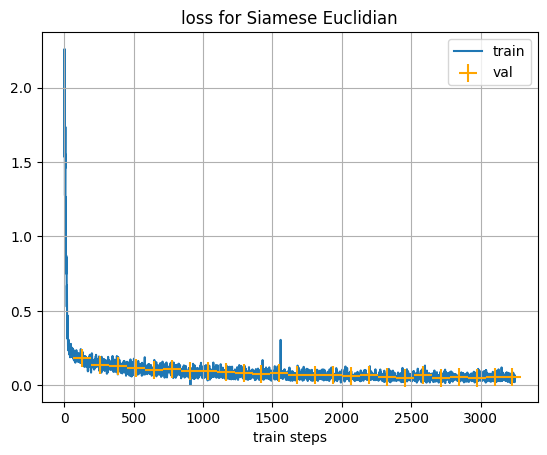

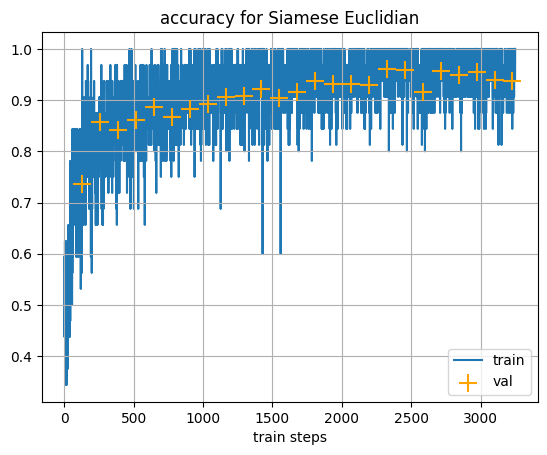

Loss: 0.053217284271822256
Acc: 0.9375


In [14]:
train(model_euclidian, optimizer, criterion, epochs, train_loader, val_loader, 'siamese_euclidian.pth', BALANCED_SIZE, batch_size, device=device)

In [15]:
model_cosine = SiameseNet("Siamese Cosine").to(device)
criterion = CosineLoss(margin=0.5)
optimizer = torch.optim.Adam(model_cosine.parameters(), lr=1e-4)

epochs = 25
BALANCED_SIZE = len(dataset)

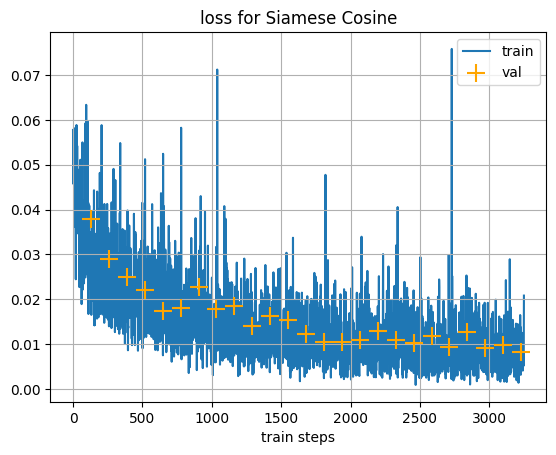

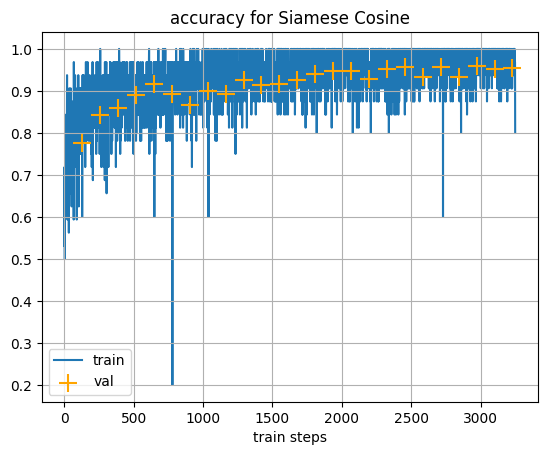

Loss: 0.00823390607119483
Acc: 0.9540441176470589
Best model saved


In [16]:
train(model_cosine, optimizer, criterion, epochs, train_loader, val_loader, 'siamese_cosine.pth', BALANCED_SIZE, batch_size, mode='cosine', device=device)

In [25]:
import matplotlib.pyplot as plt
def plot_distances(model, loader, device, mode='euclidian', threshold=None):
    model.eval()
    same_distances = []
    diff_distances = []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            img1, breed1, img2, breed2, label = [x.to(device) for x in batch]
            output1, output2 = model(img1, breed1, img2, breed2)
            if mode == 'euclidian':
                dists = F.pairwise_distance(output1, output2).cpu().numpy()
            else:
                dists = 1 - F.cosine_similarity(output1, output2).cpu().numpy()
            labels = label.cpu().numpy()
            for d, l in zip(dists, labels):
                if l == 1:
                    same_distances.append(d)
                else:
                    diff_distances.append(d)

    plt.hist(same_distances, bins=30, alpha=0.7, label='Same animal')
    plt.hist(diff_distances, bins=30, alpha=0.7, label='Different animal')
    if threshold is not None:
        plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.legend()
    plt.title(f"{'Euclidian' if mode=='euclidian' else 'Cosine'} distances")
    plt.grid()
    plt.show()

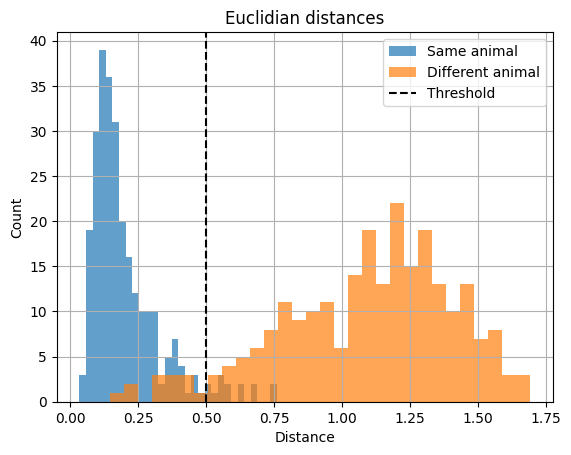

In [26]:
plot_distances(model_euclidian, test_loader, device, threshold=0.5)

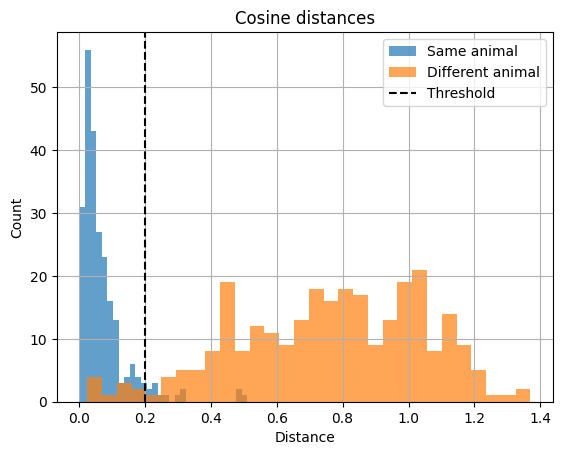

In [27]:
plot_distances(model_cosine, test_loader, device, mode='cosine', threshold=0.2)